In [1]:
# mount gdrive

from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/My Drive/ANDL/Homework_1

Mounted at /gdrive
/gdrive/My Drive/ANDL/Homework_1


In [2]:
#!unzip atMost700.zip

In [3]:
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.optimizers import adam_v2

import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import tensorflow.keras as tfk
import random
import os
import tensorflow as tf
from PIL import Image

In [4]:
# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

In [5]:
# Dataset folders 
dataset_dir = 'atMost700'
training_dir = os.path.join(dataset_dir, 'train')
validation_dir = os.path.join(dataset_dir, 'val')
test_dir = os.path.join(dataset_dir, 'test')

labels = ['Species1','Species2','Species3','Species4','Species5','Species6','Species7','Species8',]

Text(0.5, 1.0, 'Number of training images per category:')

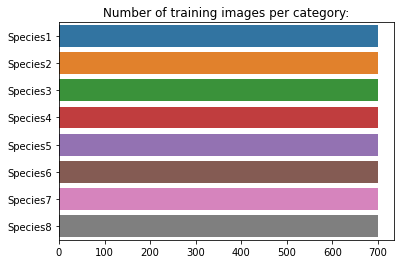

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
category_names = sorted(os.listdir(training_dir))
nb_categories = len(category_names)
img_pr_cat = []
for category in category_names:
    folder = training_dir + '/' + category
    img_pr_cat.append(len(os.listdir(folder)))
sns.barplot(y=category_names, x=img_pr_cat).set_title("Number of training images per category:")

In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import array_to_img, img_to_array, load_img

# Create an instance of ImageDataGenerator with Data Augmentation
aug_train_data_gen = ImageDataGenerator(#rotation_range=180,
                                        height_shift_range=5,
                                        width_shift_range=5,
                                        #zoom_range=0.5,
                                        horizontal_flip=True,
                                        vertical_flip=True, 
                                        #fill_mode='nearest',
                                        preprocessing_function = preprocess_input,
                                        # rescale=1/255. not on vgg16
                                        ) 
valid_data_gen = ImageDataGenerator(#rescale=1/255.,
                                    preprocessing_function = preprocess_input)
test_data_gen = ImageDataGenerator(#rescale=1/255.,
                                   preprocessing_function = preprocess_input)

In [8]:
# Obtain a data generator with the 'ImageDataGenerator.flow_from_directory' method
aug_train_gen = aug_train_data_gen.flow_from_directory(directory=training_dir,
                                                       target_size=(96,96),
                                                       color_mode='rgb',
                                                       classes=None, # can be set to labels
                                                       class_mode='categorical',
                                                       batch_size=64,
                                                       shuffle=True,
                                                       seed=seed)

valid_gen = valid_data_gen.flow_from_directory(directory=validation_dir,
                                               target_size=(96,96),
                                               color_mode='rgb',
                                               classes=None, # can be set to labels
                                               class_mode='categorical',
                                               batch_size=64,
                                               shuffle=True,
                                               seed=seed)
test_gen = test_data_gen.flow_from_directory(directory=test_dir,
                                             target_size=(96,96),
                                             color_mode='rgb',
                                             classes=None, # can be set to labels
                                             class_mode='categorical',
                                             batch_size=64,
                                             shuffle=False,
                                             seed=seed)

Found 5600 images belonging to 8 classes.
Found 527 images belonging to 8 classes.
Found 361 images belonging to 8 classes.


In [9]:
def get_next_batch(generator):
  batch = next(generator)

  image = batch[0]
  target = batch[1]

  print("(Input) image shape:", image.shape)
  print("Target shape:",target.shape)

  # Visualize only the first sample
  image = image[0]
  target = target[0]
  target_idx = np.argmax(target)
  print()
  print("Categorical label:", target)
  print("Label:", target_idx)
  print("Class name:", labels[target_idx])
  fig = plt.figure(figsize=(6, 4))
  plt.imshow(np.uint8(image))

  return batch

(Input) image shape: (64, 96, 96, 3)
Target shape: (64, 8)

Categorical label: [0. 0. 0. 0. 0. 0. 1. 0.]
Label: 6
Class name: Species7


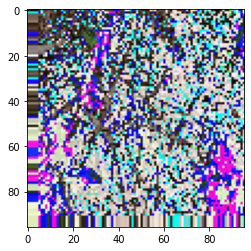

In [10]:
# Get a sample from dataset and show info
_ = get_next_batch(aug_train_gen)

In [11]:
# Utility function to create folders and callbacks for training
from datetime import datetime

def create_folders_and_callbacks(model_name):

  exps_dir = os.path.join('data_augmentation_experiments')
  if not os.path.exists(exps_dir):
      os.makedirs(exps_dir)

  now = datetime.now().strftime('%b%d_%H-%M-%S')

  exp_dir = os.path.join(exps_dir, model_name + '_' + str(now))
  if not os.path.exists(exp_dir):
      os.makedirs(exp_dir)
      
  callbacks = []

  # Model checkpoint
  # ----------------
  ckpt_dir = os.path.join(exp_dir, 'ckpts')
  if not os.path.exists(ckpt_dir):
      os.makedirs(ckpt_dir)

  ckpt_callback = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(ckpt_dir, 'cp.ckpt'), 
                                                     save_weights_only=False, # True to save only weights
                                                     save_best_only=False) # True to save only the best epoch 
  callbacks.append(ckpt_callback)

  # Visualize Learning on Tensorboard
  # ---------------------------------
  tb_dir = os.path.join(exp_dir, 'tb_logs')
  if not os.path.exists(tb_dir):
      os.makedirs(tb_dir)
      
  # By default shows losses and metrics for both training and validation
  tb_callback = tf.keras.callbacks.TensorBoard(log_dir=tb_dir, 
                                               profile_batch=0,
                                               histogram_freq=1)  # if > 0 (epochs) shows weights histograms
  callbacks.append(tb_callback)

  # Early Stopping
  # --------------
  es_callback  = tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=10, restore_best_weights=True)
  callbacks.append(es_callback)

  return callbacks

58889256/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 96, 96, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 96, 96, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 48, 48, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 48, 48, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 48, 48, 128)       147584    
                                                              

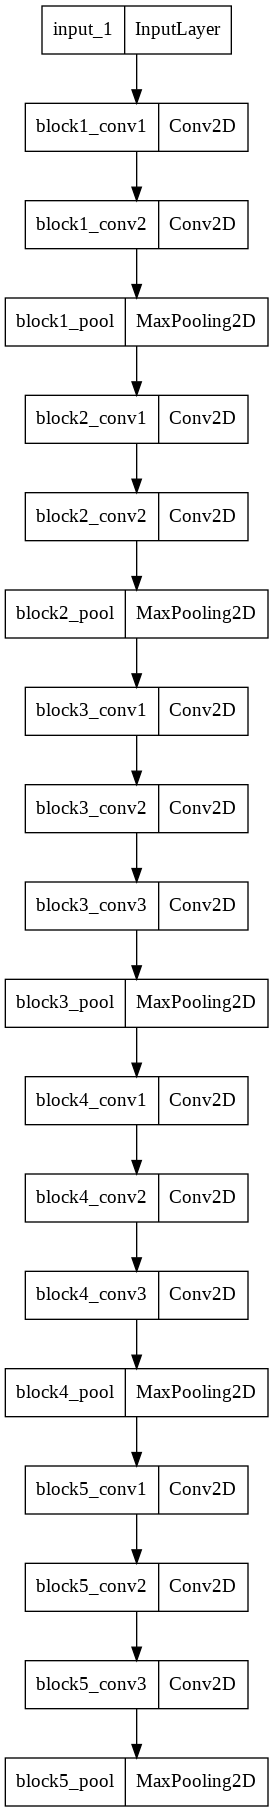

In [12]:
# Download and plot the VGG16 model
supernet = tfk.applications.VGG16(
    include_top=False,
    weights="imagenet",
    input_shape=(96,96,3)
)
supernet.summary()
tfk.utils.plot_model(supernet)

In [13]:
input_shape = (96, 96, 3)
epochs = 200

In [14]:
import tensorflow.keras.layers as tfkl

# Use the supernet as feature extractor
supernet.trainable = False

inputs = tfk.Input(shape=(96,96,3))
# No resize
#x = tfkl.Resizing(64, 64, interpolation="bicubic")(inputs)
x = supernet(inputs)
x = tfkl.Flatten(name='Flattening')(x)
x = tfkl.Dropout(0.3, seed=seed)(x)
x = tfkl.Dense(
    256, 
    activation='relu',
    kernel_initializer = tfk.initializers.GlorotUniform(seed))(x)
x = tfkl.Dropout(0.3, seed=seed)(x)
output_layer = tfkl.Dense(units=8, activation='softmax', kernel_initializer=tfk.initializers.GlorotUniform(seed), name='Output')(x)



# Connect input and output through the Model class
tl_model = tfk.Model(inputs=inputs, outputs=output_layer, name='model')

# Compile the model
tl_model.compile(loss='categorical_crossentropy', optimizer=tfk.optimizers.Adam(), metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
tl_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 vgg16 (Functional)          (None, 3, 3, 512)         14714688  
                                                                 
 Flattening (Flatten)        (None, 4608)              0         
                                                                 
 dropout (Dropout)           (None, 4608)              0         
                                                                 
 dense (Dense)               (None, 256)               1179904   
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 Output (Dense)              (None, 8)                 2056  

In [15]:
for i, layer in enumerate(tl_model.get_layer('vgg16').layers):
   layer.trainable = False

for i, layer in enumerate(tl_model.get_layer('vgg16').layers):
   print(i, layer.name, layer.trainable)

0 input_1 False
1 block1_conv1 False
2 block1_conv2 False
3 block1_pool False
4 block2_conv1 False
5 block2_conv2 False
6 block2_pool False
7 block3_conv1 False
8 block3_conv2 False
9 block3_conv3 False
10 block3_pool False
11 block4_conv1 False
12 block4_conv2 False
13 block4_conv3 False
14 block4_pool False
15 block5_conv1 False
16 block5_conv2 False
17 block5_conv3 False
18 block5_pool False


In [16]:
# Train the model
tl_callbacks = create_folders_and_callbacks(model_name = 'transfer_learning')

# Train the model
tl_history = tl_model.fit(
    x = aug_train_gen,
    epochs = epochs,
    validation_data = valid_gen,
    callbacks = tl_callbacks,
    #class_weight=class_weight
).history

Epoch 1/200
88/88 [==============================] - ETA: 0s - loss: 3.4993 - accuracy: 0.3980 - precision: 0.4461 - recall: 0.3111

88/88 [==============================] - 889s 10s/step - loss: 3.4993 - accuracy: 0.3980 - precision: 0.4461 - recall: 0.3111 - val_loss: 1.4170 - val_accuracy: 0.4915 - val_precision: 0.7515 - val_recall: 0.2410
Epoch 2/200
88/88 [==============================] - ETA: 0s - loss: 1.4264 - accuracy: 0.5038 - precision: 0.6340 - recall: 0.3541

88/88 [==============================] - 28s 316ms/step - loss: 1.4264 - accuracy: 0.5038 - precision: 0.6340 - recall: 0.3541 - val_loss: 1.2345 - val_accuracy: 0.5294 - val_precision: 0.7588 - val_recall: 0.3283
Epoch 3/200
88/88 [==============================] - ETA: 0s - loss: 1.2181 - accuracy: 0.5661 - precision: 0.6995 - recall: 0.4248

88/88 [==============================] - 27s 312ms/step - loss: 1.2181 - accuracy: 0.5661 - precision: 0.6995 - recall: 0.4248 - val_loss: 1.1266 - val_accuracy: 0.5617 - val_precision: 0.7391 - val_recall: 0.3548
Epoch 4/200
88/88 [==============================] - ETA: 0s - loss: 1.1493 - accuracy: 0.5775 - precision: 0.7008 - recall: 0.4409

88/88 [==============================] - 28s 315ms/step - loss: 1.1493 - accuracy: 0.5775 - precision: 0.7008 - recall: 0.4409 - val_loss: 1.1194 - val_accuracy: 0.5769 - val_precision: 0.7552 - val_recall: 0.4099
Epoch 5/200
88/88 [==============================] - ETA: 0s - loss: 1.0227 - accuracy: 0.6204 - precision: 0.7319 - recall: 0.5059

88/88 [==============================] - 27s 310ms/step - loss: 1.0227 - accuracy: 0.6204 - precision: 0.7319 - recall: 0.5059 - val_loss: 1.0667 - val_accuracy: 0.5863 - val_precision: 0.7265 - val_recall: 0.4839
Epoch 6/200
88/88 [==============================] - ETA: 0s - loss: 0.9975 - accuracy: 0.6359 - precision: 0.7312 - recall: 0.5280

88/88 [==============================] - 27s 312ms/step - loss: 0.9975 - accuracy: 0.6359 - precision: 0.7312 - recall: 0.5280 - val_loss: 1.0386 - val_accuracy: 0.5769 - val_precision: 0.7264 - val_recall: 0.4535
Epoch 7/200
88/88 [==============================] - ETA: 0s - loss: 0.9427 - accuracy: 0.6571 - precision: 0.7509 - recall: 0.5459

88/88 [==============================] - 27s 309ms/step - loss: 0.9427 - accuracy: 0.6571 - precision: 0.7509 - recall: 0.5459 - val_loss: 1.0111 - val_accuracy: 0.6167 - val_precision: 0.7421 - val_recall: 0.4915
Epoch 8/200
88/88 [==============================] - ETA: 0s - loss: 0.9140 - accuracy: 0.6677 - precision: 0.7687 - recall: 0.5702

88/88 [==============================] - 27s 311ms/step - loss: 0.9140 - accuracy: 0.6677 - precision: 0.7687 - recall: 0.5702 - val_loss: 1.0180 - val_accuracy: 0.6129 - val_precision: 0.7188 - val_recall: 0.4801
Epoch 9/200
88/88 [==============================] - ETA: 0s - loss: 0.8743 - accuracy: 0.6812 - precision: 0.7692 - recall: 0.5843

88/88 [==============================] - 27s 311ms/step - loss: 0.8743 - accuracy: 0.6812 - precision: 0.7692 - recall: 0.5843 - val_loss: 0.9736 - val_accuracy: 0.6395 - val_precision: 0.7413 - val_recall: 0.5275
Epoch 10/200
88/88 [==============================] - ETA: 0s - loss: 0.8603 - accuracy: 0.6873 - precision: 0.7804 - recall: 0.5954

88/88 [==============================] - 27s 307ms/step - loss: 0.8603 - accuracy: 0.6873 - precision: 0.7804 - recall: 0.5954 - val_loss: 0.9735 - val_accuracy: 0.6224 - val_precision: 0.7872 - val_recall: 0.4915
Epoch 11/200
88/88 [==============================] - ETA: 0s - loss: 0.8290 - accuracy: 0.7021 - precision: 0.7887 - recall: 0.6127

88/88 [==============================] - 28s 314ms/step - loss: 0.8290 - accuracy: 0.7021 - precision: 0.7887 - recall: 0.6127 - val_loss: 0.9543 - val_accuracy: 0.6357 - val_precision: 0.7493 - val_recall: 0.5218
Epoch 12/200
88/88 [==============================] - ETA: 0s - loss: 0.8059 - accuracy: 0.7064 - precision: 0.7958 - recall: 0.6236

88/88 [==============================] - 27s 312ms/step - loss: 0.8059 - accuracy: 0.7064 - precision: 0.7958 - recall: 0.6236 - val_loss: 0.9691 - val_accuracy: 0.6433 - val_precision: 0.7410 - val_recall: 0.5484
Epoch 13/200
88/88 [==============================] - ETA: 0s - loss: 0.7927 - accuracy: 0.7093 - precision: 0.7937 - recall: 0.6245

88/88 [==============================] - 27s 313ms/step - loss: 0.7927 - accuracy: 0.7093 - precision: 0.7937 - recall: 0.6245 - val_loss: 0.9861 - val_accuracy: 0.6338 - val_precision: 0.7292 - val_recall: 0.5313
Epoch 14/200
88/88 [==============================] - ETA: 0s - loss: 0.7647 - accuracy: 0.7171 - precision: 0.7886 - recall: 0.6363

88/88 [==============================] - 27s 307ms/step - loss: 0.7647 - accuracy: 0.7171 - precision: 0.7886 - recall: 0.6363 - val_loss: 0.9618 - val_accuracy: 0.6395 - val_precision: 0.7423 - val_recall: 0.5465
Epoch 15/200
88/88 [==============================] - ETA: 0s - loss: 0.7687 - accuracy: 0.7200 - precision: 0.8049 - recall: 0.6439

88/88 [==============================] - 27s 312ms/step - loss: 0.7687 - accuracy: 0.7200 - precision: 0.8049 - recall: 0.6439 - val_loss: 0.9789 - val_accuracy: 0.6376 - val_precision: 0.7461 - val_recall: 0.5465
Epoch 16/200
88/88 [==============================] - ETA: 0s - loss: 0.7389 - accuracy: 0.7261 - precision: 0.8045 - recall: 0.6571

88/88 [==============================] - 27s 306ms/step - loss: 0.7389 - accuracy: 0.7261 - precision: 0.8045 - recall: 0.6571 - val_loss: 1.0026 - val_accuracy: 0.6224 - val_precision: 0.7109 - val_recall: 0.5180
Epoch 17/200
88/88 [==============================] - ETA: 0s - loss: 0.7235 - accuracy: 0.7393 - precision: 0.8146 - recall: 0.6612

88/88 [==============================] - 27s 309ms/step - loss: 0.7235 - accuracy: 0.7393 - precision: 0.8146 - recall: 0.6612 - val_loss: 0.9392 - val_accuracy: 0.6546 - val_precision: 0.7544 - val_recall: 0.5712
Epoch 18/200
88/88 [==============================] - ETA: 0s - loss: 0.7065 - accuracy: 0.7427 - precision: 0.8109 - recall: 0.6768

88/88 [==============================] - 27s 308ms/step - loss: 0.7065 - accuracy: 0.7427 - precision: 0.8109 - recall: 0.6768 - val_loss: 0.9462 - val_accuracy: 0.6433 - val_precision: 0.7410 - val_recall: 0.5484
Epoch 19/200
88/88 [==============================] - ETA: 0s - loss: 0.7197 - accuracy: 0.7466 - precision: 0.8181 - recall: 0.6737

88/88 [==============================] - 27s 308ms/step - loss: 0.7197 - accuracy: 0.7466 - precision: 0.8181 - recall: 0.6737 - val_loss: 0.9841 - val_accuracy: 0.6414 - val_precision: 0.7395 - val_recall: 0.5332
Epoch 20/200
88/88 [==============================] - ETA: 0s - loss: 0.6987 - accuracy: 0.7450 - precision: 0.8153 - recall: 0.6700

88/88 [==============================] - 27s 309ms/step - loss: 0.6987 - accuracy: 0.7450 - precision: 0.8153 - recall: 0.6700 - val_loss: 0.9346 - val_accuracy: 0.6660 - val_precision: 0.7506 - val_recall: 0.5598
Epoch 21/200
88/88 [==============================] - ETA: 0s - loss: 0.6853 - accuracy: 0.7525 - precision: 0.8234 - recall: 0.6829

88/88 [==============================] - 27s 309ms/step - loss: 0.6853 - accuracy: 0.7525 - precision: 0.8234 - recall: 0.6829 - val_loss: 0.9243 - val_accuracy: 0.6641 - val_precision: 0.7568 - val_recall: 0.5844
Epoch 22/200
88/88 [==============================] - ETA: 0s - loss: 0.6703 - accuracy: 0.7630 - precision: 0.8275 - recall: 0.6939

88/88 [==============================] - 27s 305ms/step - loss: 0.6703 - accuracy: 0.7630 - precision: 0.8275 - recall: 0.6939 - val_loss: 0.9521 - val_accuracy: 0.6546 - val_precision: 0.7358 - val_recall: 0.5655
Epoch 23/200
88/88 [==============================] - ETA: 0s - loss: 0.6899 - accuracy: 0.7566 - precision: 0.8269 - recall: 0.6891

88/88 [==============================] - 28s 313ms/step - loss: 0.6899 - accuracy: 0.7566 - precision: 0.8269 - recall: 0.6891 - val_loss: 0.9451 - val_accuracy: 0.6603 - val_precision: 0.7519 - val_recall: 0.5579
Epoch 24/200
88/88 [==============================] - ETA: 0s - loss: 0.6578 - accuracy: 0.7575 - precision: 0.8251 - recall: 0.6891

88/88 [==============================] - 27s 308ms/step - loss: 0.6578 - accuracy: 0.7575 - precision: 0.8251 - recall: 0.6891 - val_loss: 0.9022 - val_accuracy: 0.6490 - val_precision: 0.7315 - val_recall: 0.5636
Epoch 25/200
88/88 [==============================] - ETA: 0s - loss: 0.6452 - accuracy: 0.7641 - precision: 0.8265 - recall: 0.7020

88/88 [==============================] - 27s 310ms/step - loss: 0.6452 - accuracy: 0.7641 - precision: 0.8265 - recall: 0.7020 - val_loss: 0.9096 - val_accuracy: 0.6717 - val_precision: 0.7500 - val_recall: 0.5693
Epoch 26/200
88/88 [==============================] - ETA: 0s - loss: 0.6659 - accuracy: 0.7611 - precision: 0.8263 - recall: 0.6946

88/88 [==============================] - 27s 307ms/step - loss: 0.6659 - accuracy: 0.7611 - precision: 0.8263 - recall: 0.6946 - val_loss: 0.9640 - val_accuracy: 0.6471 - val_precision: 0.7448 - val_recall: 0.5484
Epoch 27/200
88/88 [==============================] - ETA: 0s - loss: 0.6510 - accuracy: 0.7621 - precision: 0.8257 - recall: 0.6936

88/88 [==============================] - 27s 311ms/step - loss: 0.6510 - accuracy: 0.7621 - precision: 0.8257 - recall: 0.6936 - val_loss: 0.9265 - val_accuracy: 0.6509 - val_precision: 0.7577 - val_recall: 0.5636
Epoch 28/200
88/88 [==============================] - ETA: 0s - loss: 0.6353 - accuracy: 0.7748 - precision: 0.8318 - recall: 0.7127

88/88 [==============================] - 27s 307ms/step - loss: 0.6353 - accuracy: 0.7748 - precision: 0.8318 - recall: 0.7127 - val_loss: 0.9450 - val_accuracy: 0.6679 - val_precision: 0.7373 - val_recall: 0.5806
Epoch 29/200
88/88 [==============================] - ETA: 0s - loss: 0.6291 - accuracy: 0.7745 - precision: 0.8364 - recall: 0.7196

88/88 [==============================] - 27s 309ms/step - loss: 0.6291 - accuracy: 0.7745 - precision: 0.8364 - recall: 0.7196 - val_loss: 0.9512 - val_accuracy: 0.6755 - val_precision: 0.7400 - val_recall: 0.5939
Epoch 30/200
88/88 [==============================] - ETA: 0s - loss: 0.6371 - accuracy: 0.7759 - precision: 0.8284 - recall: 0.7154

88/88 [==============================] - 27s 309ms/step - loss: 0.6371 - accuracy: 0.7759 - precision: 0.8284 - recall: 0.7154 - val_loss: 0.9627 - val_accuracy: 0.6622 - val_precision: 0.7362 - val_recall: 0.5825
Epoch 31/200
88/88 [==============================] - ETA: 0s - loss: 0.5987 - accuracy: 0.7866 - precision: 0.8428 - recall: 0.7293

88/88 [==============================] - 27s 307ms/step - loss: 0.5987 - accuracy: 0.7866 - precision: 0.8428 - recall: 0.7293 - val_loss: 0.8975 - val_accuracy: 0.6774 - val_precision: 0.7565 - val_recall: 0.6072
Epoch 32/200
88/88 [==============================] - ETA: 0s - loss: 0.6034 - accuracy: 0.7839 - precision: 0.8414 - recall: 0.7293

88/88 [==============================] - 27s 308ms/step - loss: 0.6034 - accuracy: 0.7839 - precision: 0.8414 - recall: 0.7293 - val_loss: 0.9572 - val_accuracy: 0.6565 - val_precision: 0.7200 - val_recall: 0.5806
Epoch 33/200
88/88 [==============================] - ETA: 0s - loss: 0.6055 - accuracy: 0.7868 - precision: 0.8414 - recall: 0.7277

88/88 [==============================] - 27s 308ms/step - loss: 0.6055 - accuracy: 0.7868 - precision: 0.8414 - recall: 0.7277 - val_loss: 0.9174 - val_accuracy: 0.6622 - val_precision: 0.7439 - val_recall: 0.5787
Epoch 34/200
88/88 [==============================] - ETA: 0s - loss: 0.6113 - accuracy: 0.7812 - precision: 0.8360 - recall: 0.7218

88/88 [==============================] - 27s 312ms/step - loss: 0.6113 - accuracy: 0.7812 - precision: 0.8360 - recall: 0.7218 - val_loss: 0.9352 - val_accuracy: 0.6546 - val_precision: 0.7172 - val_recall: 0.6015
Epoch 35/200
88/88 [==============================] - ETA: 0s - loss: 0.5821 - accuracy: 0.7893 - precision: 0.8457 - recall: 0.7380

88/88 [==============================] - 27s 307ms/step - loss: 0.5821 - accuracy: 0.7893 - precision: 0.8457 - recall: 0.7380 - val_loss: 0.9308 - val_accuracy: 0.6660 - val_precision: 0.7641 - val_recall: 0.5901
Epoch 36/200
88/88 [==============================] - ETA: 0s - loss: 0.5954 - accuracy: 0.7916 - precision: 0.8429 - recall: 0.7311

88/88 [==============================] - 27s 308ms/step - loss: 0.5954 - accuracy: 0.7916 - precision: 0.8429 - recall: 0.7311 - val_loss: 0.9252 - val_accuracy: 0.6812 - val_precision: 0.7445 - val_recall: 0.5750
Epoch 37/200
88/88 [==============================] - ETA: 0s - loss: 0.6098 - accuracy: 0.7798 - precision: 0.8346 - recall: 0.7211

88/88 [==============================] - 27s 307ms/step - loss: 0.6098 - accuracy: 0.7798 - precision: 0.8346 - recall: 0.7211 - val_loss: 0.9054 - val_accuracy: 0.6774 - val_precision: 0.7465 - val_recall: 0.6034
Epoch 38/200
88/88 [==============================] - ETA: 0s - loss: 0.5919 - accuracy: 0.7918 - precision: 0.8396 - recall: 0.7364

88/88 [==============================] - 27s 310ms/step - loss: 0.5919 - accuracy: 0.7918 - precision: 0.8396 - recall: 0.7364 - val_loss: 0.9457 - val_accuracy: 0.6869 - val_precision: 0.7518 - val_recall: 0.5920
Epoch 39/200
88/88 [==============================] - ETA: 0s - loss: 0.5727 - accuracy: 0.7982 - precision: 0.8545 - recall: 0.7437

88/88 [==============================] - 27s 306ms/step - loss: 0.5727 - accuracy: 0.7982 - precision: 0.8545 - recall: 0.7437 - val_loss: 0.9599 - val_accuracy: 0.6584 - val_precision: 0.7110 - val_recall: 0.5787
Epoch 40/200
88/88 [==============================] - ETA: 0s - loss: 0.5579 - accuracy: 0.8020 - precision: 0.8552 - recall: 0.7507

88/88 [==============================] - 27s 308ms/step - loss: 0.5579 - accuracy: 0.8020 - precision: 0.8552 - recall: 0.7507 - val_loss: 0.9034 - val_accuracy: 0.6584 - val_precision: 0.7428 - val_recall: 0.5863
Epoch 41/200
88/88 [==============================] - ETA: 0s - loss: 0.5874 - accuracy: 0.7898 - precision: 0.8399 - recall: 0.7393

88/88 [==============================] - 27s 306ms/step - loss: 0.5874 - accuracy: 0.7898 - precision: 0.8399 - recall: 0.7393 - val_loss: 0.9199 - val_accuracy: 0.6622 - val_precision: 0.7482 - val_recall: 0.5806
Epoch 42/200
88/88 [==============================] - ETA: 0s - loss: 0.5522 - accuracy: 0.8079 - precision: 0.8639 - recall: 0.7504

88/88 [==============================] - 27s 309ms/step - loss: 0.5522 - accuracy: 0.8079 - precision: 0.8639 - recall: 0.7504 - val_loss: 0.8918 - val_accuracy: 0.6850 - val_precision: 0.7571 - val_recall: 0.6091
Epoch 43/200
88/88 [==============================] - ETA: 0s - loss: 0.5613 - accuracy: 0.8023 - precision: 0.8536 - recall: 0.7455

88/88 [==============================] - 27s 306ms/step - loss: 0.5613 - accuracy: 0.8023 - precision: 0.8536 - recall: 0.7455 - val_loss: 0.9271 - val_accuracy: 0.6660 - val_precision: 0.7470 - val_recall: 0.5939
Epoch 44/200
88/88 [==============================] - ETA: 0s - loss: 0.5695 - accuracy: 0.7964 - precision: 0.8493 - recall: 0.7457

88/88 [==============================] - 27s 310ms/step - loss: 0.5695 - accuracy: 0.7964 - precision: 0.8493 - recall: 0.7457 - val_loss: 0.9122 - val_accuracy: 0.6679 - val_precision: 0.7326 - val_recall: 0.5977
Epoch 45/200
88/88 [==============================] - ETA: 0s - loss: 0.5713 - accuracy: 0.7973 - precision: 0.8513 - recall: 0.7461

88/88 [==============================] - 28s 313ms/step - loss: 0.5713 - accuracy: 0.7973 - precision: 0.8513 - recall: 0.7461 - val_loss: 0.9264 - val_accuracy: 0.6717 - val_precision: 0.7518 - val_recall: 0.5977
Epoch 46/200
88/88 [==============================] - ETA: 0s - loss: 0.5288 - accuracy: 0.8200 - precision: 0.8667 - recall: 0.7654

88/88 [==============================] - 27s 311ms/step - loss: 0.5288 - accuracy: 0.8200 - precision: 0.8667 - recall: 0.7654 - val_loss: 0.9563 - val_accuracy: 0.6888 - val_precision: 0.7500 - val_recall: 0.6205
Epoch 47/200
88/88 [==============================] - ETA: 0s - loss: 0.5295 - accuracy: 0.8093 - precision: 0.8531 - recall: 0.7602

88/88 [==============================] - 27s 305ms/step - loss: 0.5295 - accuracy: 0.8093 - precision: 0.8531 - recall: 0.7602 - val_loss: 0.9410 - val_accuracy: 0.6888 - val_precision: 0.7599 - val_recall: 0.6186
Epoch 48/200
88/88 [==============================] - ETA: 0s - loss: 0.5344 - accuracy: 0.8075 - precision: 0.8582 - recall: 0.7575

88/88 [==============================] - 27s 310ms/step - loss: 0.5344 - accuracy: 0.8075 - precision: 0.8582 - recall: 0.7575 - val_loss: 0.9338 - val_accuracy: 0.6755 - val_precision: 0.7483 - val_recall: 0.6148
Epoch 49/200
88/88 [==============================] - ETA: 0s - loss: 0.5619 - accuracy: 0.8030 - precision: 0.8556 - recall: 0.7568

88/88 [==============================] - 27s 307ms/step - loss: 0.5619 - accuracy: 0.8030 - precision: 0.8556 - recall: 0.7568 - val_loss: 0.9911 - val_accuracy: 0.6660 - val_precision: 0.7524 - val_recall: 0.5996
Epoch 50/200
88/88 [==============================] - ETA: 0s - loss: 0.5271 - accuracy: 0.8095 - precision: 0.8551 - recall: 0.7641

88/88 [==============================] - 27s 308ms/step - loss: 0.5271 - accuracy: 0.8095 - precision: 0.8551 - recall: 0.7641 - val_loss: 0.9974 - val_accuracy: 0.6471 - val_precision: 0.7252 - val_recall: 0.5958
Epoch 51/200
88/88 [==============================] - ETA: 0s - loss: 0.5563 - accuracy: 0.8070 - precision: 0.8559 - recall: 0.7554

88/88 [==============================] - 27s 304ms/step - loss: 0.5563 - accuracy: 0.8070 - precision: 0.8559 - recall: 0.7554 - val_loss: 0.9772 - val_accuracy: 0.6528 - val_precision: 0.7153 - val_recall: 0.5863
Epoch 52/200
88/88 [==============================] - ETA: 0s - loss: 0.5231 - accuracy: 0.8177 - precision: 0.8638 - recall: 0.7704

88/88 [==============================] - 27s 308ms/step - loss: 0.5231 - accuracy: 0.8177 - precision: 0.8638 - recall: 0.7704 - val_loss: 0.9761 - val_accuracy: 0.6755 - val_precision: 0.7471 - val_recall: 0.6053
Epoch 53/200
88/88 [==============================] - ETA: 0s - loss: 0.5281 - accuracy: 0.8091 - precision: 0.8519 - recall: 0.7591

88/88 [==============================] - 27s 308ms/step - loss: 0.5281 - accuracy: 0.8091 - precision: 0.8519 - recall: 0.7591 - val_loss: 0.9927 - val_accuracy: 0.6471 - val_precision: 0.7169 - val_recall: 0.5863
Epoch 54/200
88/88 [==============================] - ETA: 0s - loss: 0.5333 - accuracy: 0.8104 - precision: 0.8643 - recall: 0.7634

88/88 [==============================] - 27s 308ms/step - loss: 0.5333 - accuracy: 0.8104 - precision: 0.8643 - recall: 0.7634 - val_loss: 0.9464 - val_accuracy: 0.6869 - val_precision: 0.7339 - val_recall: 0.6072
Epoch 55/200
88/88 [==============================] - ETA: 0s - loss: 0.5174 - accuracy: 0.8211 - precision: 0.8697 - recall: 0.7736

88/88 [==============================] - 27s 306ms/step - loss: 0.5174 - accuracy: 0.8211 - precision: 0.8697 - recall: 0.7736 - val_loss: 0.9262 - val_accuracy: 0.6736 - val_precision: 0.7646 - val_recall: 0.5977
Epoch 56/200
88/88 [==============================] - ETA: 0s - loss: 0.5229 - accuracy: 0.8148 - precision: 0.8597 - recall: 0.7695

88/88 [==============================] - 27s 307ms/step - loss: 0.5229 - accuracy: 0.8148 - precision: 0.8597 - recall: 0.7695 - val_loss: 0.9465 - val_accuracy: 0.6869 - val_precision: 0.7700 - val_recall: 0.6034


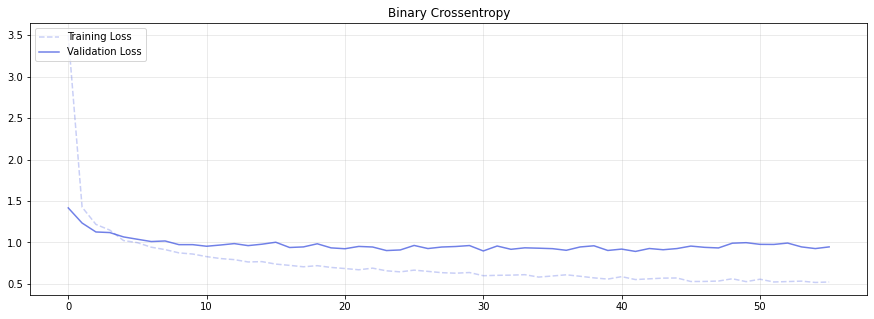

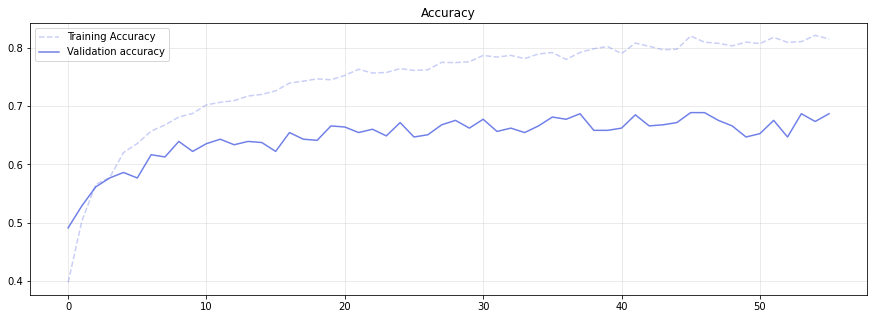

In [17]:
# Plot the training
plt.figure(figsize=(15,5))

plt.plot(tl_history['loss'],label = 'Training Loss', alpha=.3, color='#4D61E2', linestyle='--')
plt.plot(tl_history['val_loss'], label='Validation Loss', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Binary Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(15,5))

plt.plot(tl_history['accuracy'],label = 'Training Accuracy' , alpha=.3, color='#4D61E2', linestyle='--')
plt.plot(tl_history['val_accuracy'], label='Validation accuracy', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

In [18]:
tl_model.save('Vgg16/FineFineTuning_v1')

In [19]:
tl_model = tfk.models.load_model('Vgg16/FineFineTuning_v1')
tl_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 vgg16 (Functional)          (None, 3, 3, 512)         14714688  
                                                                 
 Flattening (Flatten)        (None, 4608)              0         
                                                                 
 dropout (Dropout)           (None, 4608)              0         
                                                                 
 dense (Dense)               (None, 256)               1179904   
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 Output (Dense)              (None, 8)                 2056  

In [20]:
tl_model.get_layer('vgg16').trainable = True
for i, layer in enumerate(tl_model.get_layer('vgg16').layers):
   print(i, layer.name, layer.trainable)

0 input_1 True
1 block1_conv1 True
2 block1_conv2 True
3 block1_pool True
4 block2_conv1 True
5 block2_conv2 True
6 block2_pool True
7 block3_conv1 True
8 block3_conv2 True
9 block3_conv3 True
10 block3_pool True
11 block4_conv1 True
12 block4_conv2 True
13 block4_conv3 True
14 block4_pool True
15 block5_conv1 True
16 block5_conv2 True
17 block5_conv3 True
18 block5_pool True


In [21]:
for i, layer in enumerate(tl_model.get_layer('vgg16').layers[:15]):
  layer.trainable=False
for i, layer in enumerate(tl_model.get_layer('vgg16').layers):
   print(i, layer.name, layer.trainable)
tl_model.summary()

0 input_1 False
1 block1_conv1 False
2 block1_conv2 False
3 block1_pool False
4 block2_conv1 False
5 block2_conv2 False
6 block2_pool False
7 block3_conv1 False
8 block3_conv2 False
9 block3_conv3 False
10 block3_pool False
11 block4_conv1 False
12 block4_conv2 False
13 block4_conv3 False
14 block4_pool False
15 block5_conv1 True
16 block5_conv2 True
17 block5_conv3 True
18 block5_pool True
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 vgg16 (Functional)          (None, 3, 3, 512)         14714688  
                                                                 
 Flattening (Flatten)        (None, 4608)              0         
                                                                 
 dropout (Dropout)           (None, 4608)              0       

In [22]:
tl_model.compile(loss='categorical_crossentropy', optimizer=tfk.optimizers.Adam(1e-4), metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

In [23]:
# Fine-tune the model
tl_history = tl_model.fit(
    x = aug_train_gen ,
    batch_size = 32,
    epochs = 200,
    validation_data = valid_gen,
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=10, verbose=2 , restore_best_weights=True)],
    #class_weight = class_weight
).history

Epoch 1/200
88/88 [==============================] - 25s 258ms/step - loss: 0.7986 - accuracy: 0.7402 - precision_1: 0.7976 - recall_1: 0.6764 - val_loss: 1.0040 - val_accuracy: 0.6565 - val_precision_1: 0.7476 - val_recall_1: 0.5844
Epoch 2/200
88/88 [==============================] - 22s 247ms/step - loss: 0.6760 - accuracy: 0.7698 - precision_1: 0.8317 - recall_1: 0.7166 - val_loss: 0.9434 - val_accuracy: 0.6869 - val_precision_1: 0.7535 - val_recall_1: 0.6148
Epoch 3/200
88/88 [==============================] - 22s 249ms/step - loss: 0.5734 - accuracy: 0.8025 - precision_1: 0.8490 - recall_1: 0.7550 - val_loss: 0.7840 - val_accuracy: 0.7381 - val_precision_1: 0.8059 - val_recall_1: 0.6698
Epoch 4/200
88/88 [==============================] - 22s 249ms/step - loss: 0.4733 - accuracy: 0.8345 - precision_1: 0.8770 - recall_1: 0.7895 - val_loss: 1.0137 - val_accuracy: 0.6983 - val_precision_1: 0.7554 - val_recall_1: 0.6622
Epoch 5/200
88/88 [==============================] - 22s 247ms/s

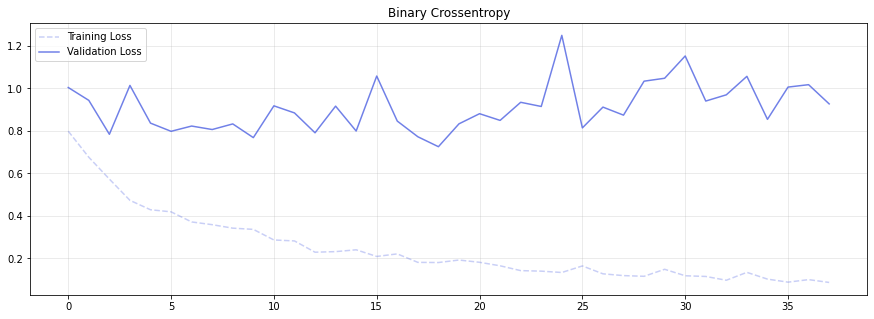

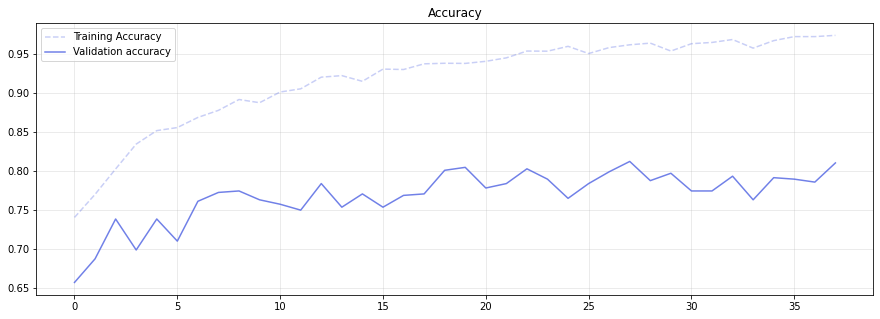

In [24]:
# Plot the training
plt.figure(figsize=(15,5))

plt.plot(tl_history['loss'],label = 'Training Loss', alpha=.3, color='#4D61E2', linestyle='--')
plt.plot(tl_history['val_loss'], label='Validation Loss', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Binary Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(15,5))

plt.plot(tl_history['accuracy'],label = 'Training Accuracy' , alpha=.3, color='#4D61E2', linestyle='--')
plt.plot(tl_history['val_accuracy'], label='Validation accuracy', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

In [25]:
%cd /gdrive/My Drive/ANDL/Homework_1

/gdrive/My Drive/ANDL/Homework_1


In [26]:
tl_model.save('Vgg16/Tuned_v1_1')

In [27]:
# Test the model
tl_model = tfk.models.load_model("Vgg16/Tuned_v1_1")
model_test_metrics = tl_model.evaluate(test_gen, return_dict=True)

print()
print("Test metrics")
print(model_test_metrics)

6/6 [==============================] - 50s 10s/step - loss: 1.1037 - accuracy: 0.7895 - precision_1: 0.7914 - recall_1: 0.7673

Test metrics
{'loss': 1.103682279586792, 'accuracy': 0.7894737124443054, 'precision_1': 0.7914285659790039, 'recall_1': 0.7673130035400391}


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  """


Accuracy: 0.7895
Precision: 0.779
Recall: 0.7675
F1: 0.7627


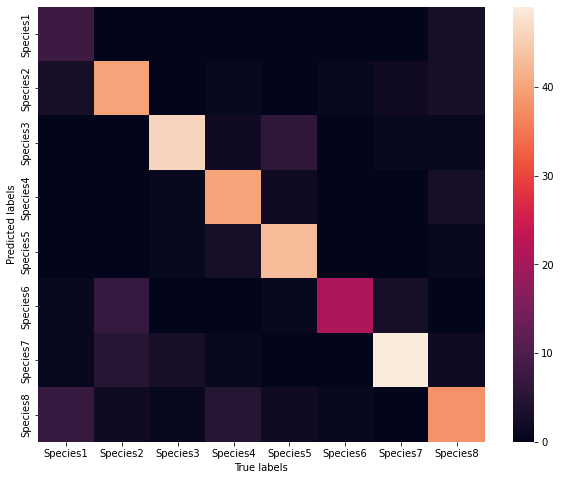

In [28]:
import seaborn as sns
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix

predictions = tl_model.predict_generator(test_gen, steps=224)
predicted_classes = np.argmax(predictions, axis=-1)

# Compute the confusion matrix
cm = (confusion_matrix(test_gen.classes, predicted_classes))

# Compute the classification metrics
accuracy = accuracy_score(test_gen.classes, predicted_classes)
precision = precision_score(test_gen.classes, predicted_classes, average='macro')
recall = recall_score(test_gen.classes, predicted_classes, average='macro')
f1 = f1_score(test_gen.classes, predicted_classes, average='macro')
print('Accuracy:',accuracy.round(4))
print('Precision:',precision.round(4))
print('Recall:',recall.round(4))
print('F1:',f1.round(4))

# Plot the confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(cm.T, xticklabels=labels, yticklabels=labels)
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()